# AARDVARC Calibration Channel

The AARDVARCv3/4 boards have a special "calibration" feature which can be used to swap the signal digitized for a given channel with a calibration signal. This is useful for scenarios where the board setup cannot be modified to include a calibration signal in the signal path. 

There are two calibration signals which may be selected from: the user-connected (external) calibration signal and the internal calibration signal. The user-connected calibration signal is a signal which is connected to the calibration input on the AARDVARC board. The internal calibration signal is a signal which is generated by the AARDVARC board itself. The external calibration signal has a customizable external bias using the DAC controller just as the other channels. The input to each regular channel may be thought of as a MUX which selects between the regular input signal, the external calibration signal, and the internal calibration signal.

Use cases:
- Generate pedestals calibration data without modifying the experiment setup
- Use the calibration channel as an additional channel by swapping out another channel

### Naludaq Version  
*Min Version*: `0.18.0`

In [ ]:
# Print Naludaq version
import naludaq
print(f"Naludaq version: {naludaq.__version__}")

### Compatible Boards
+ `AARDVARCv3`
+ `AARDVARCv4`

## Example Code

This notebook demonstrates how to use NaluDAQ to configure the AARDVARC board to use the calibration channel.

In [1]:
import time

from naludaq.board import Board, startup_board
from naludaq.controllers import (
    get_readout_controller,
    get_board_controller,
    get_dac_controller,
)
from naludaq.tools.pedestals import get_pedestals_controller
from naludaq.tools.pedestals.pedestals_correcter import PedestalsCorrecter
from naludaq.daq import DebugDaq

from naluexamples.helpers.plotting import *


def get_event(board: Board) -> dict:
    """Read a single event from the board using a software-issued external trigger."""
    daq = DebugDaq(board)
    get_readout_controller(board).set_read_window(8, 8, 8)
    daq.start_capture()
    try:
        get_board_controller(board).start_readout("ext")
        get_board_controller(board).toggle_trigger()
        time.sleep(0.5)
        get_board_controller(board).stop_readout()
    finally:
        daq.stop_capture()
    return daq.output_buffer[0]

### Board Creation and Startup

In [2]:
MODEL = "aardvarcv3"
SERIAL_NUMBER = "A904CVKK"
# Refer to BOARD.params["possible_bauds"] keys for a list of available baudrates.
BAUD_RATE = 104
BOARD = Board(MODEL)
BOARD.get_ftdi_connection(serial_number="CVKK", baud=1041667)
startup_board(BOARD)

Trying [115200, 230400, 691200, 1041667]


True

In [3]:
RC = get_readout_controller(BOARD)
DC = get_dac_controller(BOARD)

# Setup graph style
CMAP = get_color_mapping("ocean")
set_plot_style(font_size=18, font_family="monospace")

### Selecting the External Calibration Signal

The external calibration signal may be connected to the board for this purpose, but is not required to demonstrate the functionality. Care should be taken to configure the DAC value properly if connecting an external calibration signal.

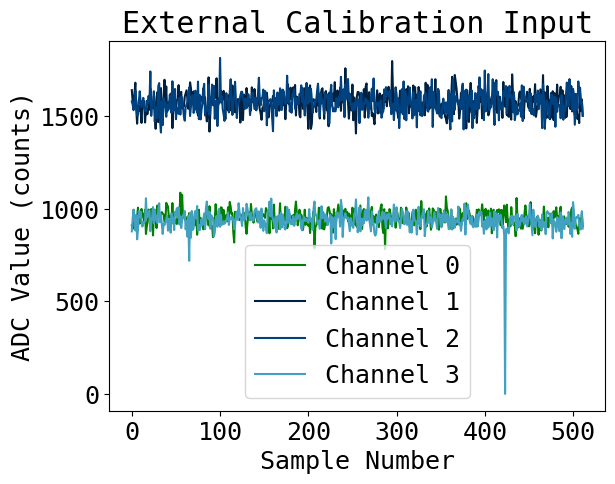

In [4]:
# Channels 0 and 3 will digitize the external calibration input.
# The other channels will not use the calibration channel.
external_channels = [0, 3]
dac_value = 1000 # counts

RC.disable_calibration_channel(list(set(range(BOARD.channels)) - set(external_channels)))
RC.enable_external_calibration_channel(external_channels)
DC.cal_dac = dac_value

event = get_event(BOARD)
simple_event_plot(event, title="External Calibration Input", cmap=CMAP)

### Selecting the Internal Calibration Signal

The internal calibration signal is defined by one of the clocks internal to the ASIC. The internal signal is not configurable, and setting the external DAC for the calibration channel will not shift the baseline of the signal. The main use case for the internal calibration signal is to debug the board.

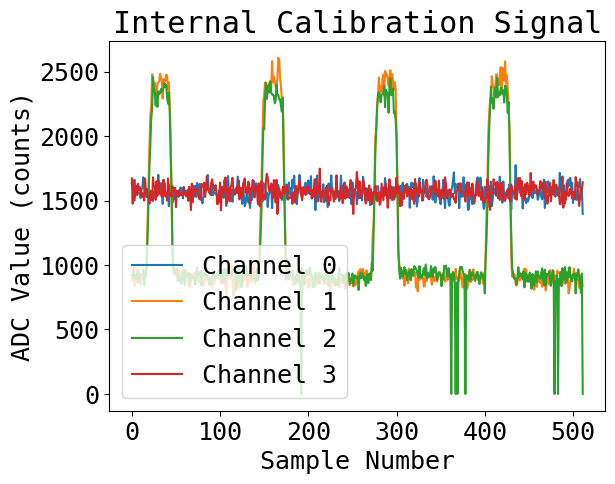

In [8]:
# Channels 1 and 2 will digitize the internal calibration signal.
# The other channels will not use the calibration signal.
internal_channels = [1, 2]

RC.disable_calibration_channel(list(set(range(BOARD.channels)) - set(internal_channels)))
RC.enable_internal_calibration_channel(internal_channels)

event = get_event(BOARD)
simple_event_plot(event, title="Internal Calibration Signal")

### Generating Pedestals Using the Calibration Channel

Pedestals may be generated using the calibration channel by enabling the external calibration channel and setting the external DAC to the desired value. There should be no signal connected to the calibration input on the board.

In [9]:
# All channels will digitize the external calibration signal.
external_channels = [0, 1]

RC.disable_calibration_channel(list(set(range(BOARD.channels)) - set(external_channels)))
RC.enable_external_calibration_channel(external_channels)

In [10]:
# Pedestals are stored in BOARD.pedestals
get_pedestals_controller(BOARD, num_captures=3, num_warmup_events=1).generate_pedestals()

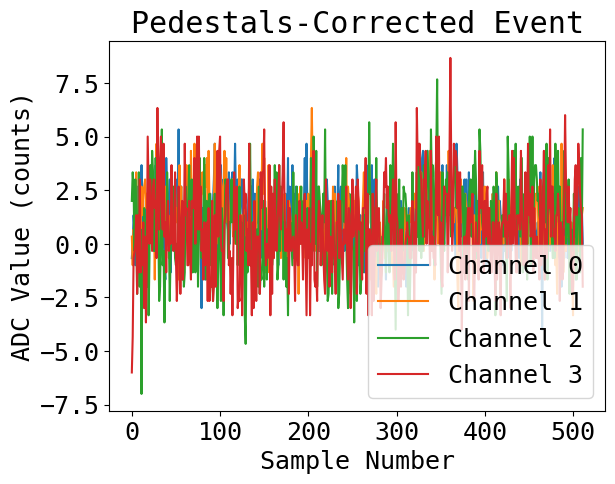

In [11]:
event = get_event(BOARD)
PedestalsCorrecter(BOARD.params, BOARD.pedestals).run(event)
simple_event_plot(event, title="Pedestals-Corrected Event")